In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
path = "youtube_comments_climate_change/cleaned_data.csv"
data = pd.read_csv(path, sep=",", encoding='utf-8')

list(data.columns)

['Unnamed: 0', 'publishedAt', 'authorName', 'text', 'isReply', 'cleaned']

In [9]:
import tensorflow as tf
import tensorflow_hub as hub

hub_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(hub_url)
embeddings = embed(data['cleaned'])

print(embeddings)
print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

tf.Tensor(
[[ 0.02267956 -0.06716511  0.01718922 ... -0.0158857  -0.043926
  -0.00393031]
 [ 0.04192     0.07056528  0.09499479 ... -0.03520851 -0.0134883
   0.04670066]
 [-0.06692986 -0.00541758 -0.03079402 ...  0.02694076 -0.01263959
  -0.07979716]
 ...
 [-0.01887087  0.06309655  0.1051517  ... -0.01325584 -0.04266983
   0.01906748]
 [ 0.01090654 -0.08720968 -0.00068635 ...  0.00569523 -0.01905336
  -0.04718436]
 [ 0.0252452  -0.01673799 -0.06606335 ... -0.00096804 -0.04874956
  -0.04058736]], shape=(25914, 512), dtype=float32)
The embeddings vector is of fixed length 512


In [10]:
np.save('embeddings.npy', embeddings, allow_pickle=True, fix_imports=True)
data.to_pickle('data.pkl')

In [3]:
embeddings = np.load('embeddings.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
data = pd.read_pickle('data.pkl')

In [4]:
from sklearn.preprocessing import normalize
_normalize =True


if (_normalize):
  embeddings = normalize(embeddings, norm='l2')

### Load embeddings into embeddings projector

In [68]:
np.savetxt("emebddings.tsv", embeddings, delimiter="\t")

Once for "\t" and once for "\n"

In [88]:
for i, row in data.iterrows():
    if "\n" in data['text'][i]:
        text = data['text'][i]
        data.at[i,'text'] = text.replace("\n", " ")

In [89]:
data['text'][17]

'Are you serious? The earth is going to do its thing regardless of if it is warming or cooling. What happens to people on the other hand, will change drastically over time if things were to go to one extreme or the other. Many people say that less people would actually be better for "the earth".  '

In [90]:
import csv

pd.DataFrame(data['text']).to_csv('metadata.tsv',sep='\t', quoting=csv.QUOTE_NONE)

### PCA

#### Choosing dimensions by looking at cumulative explained variance ration

95% cut-off threshold reached with 217 components.


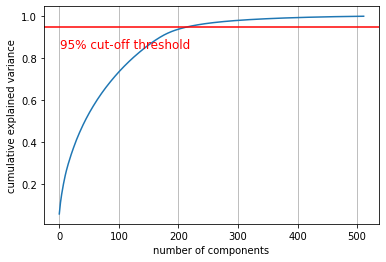

In [16]:
pca_cev = PCA().fit(embeddings)
cev_plot = np.cumsum(pca_cev.explained_variance_ratio_)
plt.plot(cev_plot)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=12)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(axis='x')

print("95% cut-off threshold reached with {} components.".format(np.argwhere(cev_plot >= 0.95)[0][0]))

In [5]:
SUBSPACE_DIM = 200

pca = PCA(n_components= SUBSPACE_DIM)
pca_embeddings = pca.fit_transform(embeddings)

print("Dimensions of embeddings matrix after PCA: ({}, {})".format(pca_embeddings.shape[0], pca_embeddings.shape[1]))

Dimensions of embeddings matrix after PCA: (25914, 200)


### SVD

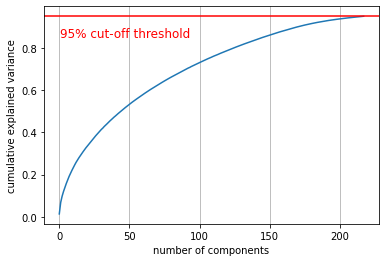

In [50]:
svd_plot = []
for i in range(1,512):
    svd_cev = TruncatedSVD(n_components=i).fit(embeddings)
    sum = svd_cev.explained_variance_ratio_.sum()
    svd_plot.append(sum)
    if sum >= 0.95:
        break


plt.plot(svd_plot)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=12)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(axis='x')

In [6]:
SUBSPACE_DIM = 200

svd = TruncatedSVD(n_components= SUBSPACE_DIM)
svd_embeddings = svd.fit_transform(embeddings)

print("Dimensions of embeddings matrix after PCA: ({}, {})".format(svd_embeddings.shape[0], svd_embeddings.shape[1]))

Dimensions of embeddings matrix after PCA: (25914, 200)


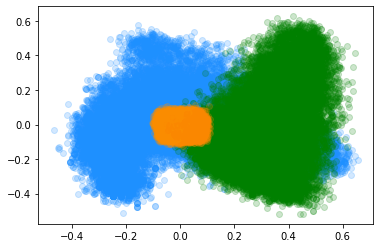

In [9]:
# plot data after pca
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], color = "dodgerblue", alpha=0.2)
plt.scatter(svd_embeddings[:, 0], svd_embeddings[:, 1], color = "green", alpha=0.2)
plt.scatter(embeddings[:, 0], embeddings[:, 1], color = "darkorange", alpha=0.2)

### Evaluating an optimal number of clusters

In [17]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_pca = sc.fit_transform(pca_embeddings) #ehemals X_normalized
X_svd = sc.fit_transform(svd_embeddings)

In [20]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

sse_pca, sse_svd, db_pca, db_svd, slc_pca, slc_svd = {}, {}, {}, {}, {}, {}
for k in range(5, 105, 5):
    kmeans_svd = KMeans(n_clusters = k, max_iter=1000, random_state=10).fit(X_svd)
    kmeans_pca = KMeans(n_clusters = k, max_iter=1000, random_state=10).fit(X_pca)
    clusters_pca = kmeans_pca.labels_
    clusters_svd = kmeans_svd.labels_
    sse_pca[k] = kmeans_pca.inertia_
    sse_svd[k] = kmeans_svd.inertia_
    db_pca[k] = davies_bouldin_score(X_pca, clusters_pca)
    db_svd[k] = davies_bouldin_score(X_svd, clusters_svd)
    slc_pca[k] = silhouette_score(X_pca, clusters_pca)
    slc_svd[k] = silhouette_score(X_svd, clusters_svd)

In [46]:
from sklearn_extra.cluster import KMedoids

kmedoids_sse_pca, kmedoids_sse_svd, kmedoids_db_pca, kmedoids_db_svd, kmedoids_slc_pca, kmedoids_slc_svd = {}, {}, {}, {}, {}, {}
for k in range(60, 90, 10):
    kmedoids_svd = KMedoids(n_clusters = k, max_iter=1000, random_state=10).fit(X_svd)
    kmedoids_pca = KMedoids(n_clusters = k, max_iter=1000, random_state=10).fit(X_pca)
    kmedoids_clusters_pca = kmedoids_pca.labels_
    kmedoids_clusters_svd = kmedoids_svd.labels_
    kmedoids_sse_pca[k] = kmedoids_pca.inertia_
    kmedoids_sse_svd[k] = kmedoids_svd.inertia_
    kmedoids_db_pca[k] = davies_bouldin_score(X_pca, kmedoids_clusters_pca)
    kmedoids_db_svd[k] = davies_bouldin_score(X_svd, kmedoids_clusters_svd)
    kmedoids_slc_pca[k] = silhouette_score(X_pca, kmedoids_clusters_pca)
    kmedoids_slc_svd[k] = silhouette_score(X_svd, kmedoids_clusters_svd)

/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 5 is em

/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 49 is empty! self.labels_[self.medoid_indices_[49]] may not be labeled with its corresponding cluster (49).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 50 is empty! self.labels_[self.medoid_indices_[50]] may not be labeled with its corresponding cluster (50).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 51 is empty! self.labels_[self.medoid_indices_[51]] may not be labeled with its corresponding cluster (51).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 52 is empty! self.labels_[self.medoid_indices_[52]] may not be labeled with its corresponding cluster (52).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Clu

/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 5 is em

/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 49 is empty! self.labels_[self.medoid_indices_[49]] may not be labeled with its corresponding cluster (49).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 50 is empty! self.labels_[self.medoid_indices_[50]] may not be labeled with its corresponding cluster (50).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 51 is empty! self.labels_[self.medoid_indices_[51]] may not be labeled with its corresponding cluster (51).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 52 is empty! self.labels_[self.medoid_indices_[52]] may not be labeled with its corresponding cluster (52).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Clu

/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 21 is empty! self.labels_[self.medoid_indices_[21]] may not be labeled with its corresponding cluster (21).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 22 is empty! self.labels_[self.medoid_indices_[22]] may not be labeled with its corresponding cluster (22).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 23 is empty! self.labels_[self.medoid_indices_[23]] may not be labeled with its corresponding cluster (23).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 25 is empty! self.labels_[self.medoid_indices_[25]] may not be labeled with its corresponding cluster (25).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Clu

/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 5 is em

/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 49 is empty! self.labels_[self.medoid_indices_[49]] may not be labeled with its corresponding cluster (49).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 50 is empty! self.labels_[self.medoid_indices_[50]] may not be labeled with its corresponding cluster (50).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 51 is empty! self.labels_[self.medoid_indices_[51]] may not be labeled with its corresponding cluster (51).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 52 is empty! self.labels_[self.medoid_indices_[52]] may not be labeled with its corresponding cluster (52).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Clu

/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 21 is empty! self.labels_[self.medoid_indices_[21]] may not be labeled with its corresponding cluster (21).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 22 is empty! self.labels_[self.medoid_indices_[22]] may not be labeled with its corresponding cluster (22).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 23 is empty! self.labels_[self.medoid_indices_[23]] may not be labeled with its corresponding cluster (23).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Cluster 25 is empty! self.labels_[self.medoid_indices_[25]] may not be labeled with its corresponding cluster (25).
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:231: UserWarning: Clu

In [54]:
kmedoids_pca.labels_

array([20,  4, 20, ...,  4,  4, 28])

In [55]:
kmedoids_sse_pca

{60: 422480.75, 70: 422480.75, 80: 422480.75}

In [50]:
sse_pca

{5: 5101567.5,
 10: 5014773.0,
 15: 4948797.5,
 20: 4888541.0,
 25: 4837040.0,
 30: 4788818.5,
 35: 4742817.0,
 40: 4700158.0,
 45: 4667916.5,
 50: 4631977.0,
 55: 4598425.5,
 60: 4574953.0,
 65: 4548281.5,
 70: 4528778.5,
 75: 4500927.0,
 80: 4479494.5,
 85: 4456899.0,
 90: 4438954.0,
 95: 4419144.5,
 100: 4403931.5}

#### Elbow Method

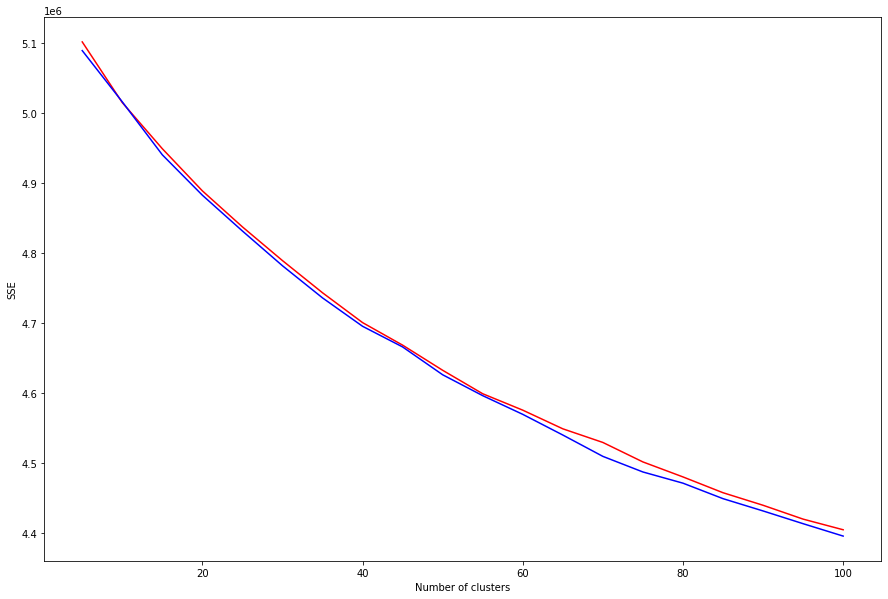

In [51]:
plt.figure(figsize=(15,10))
plt.plot(list(sse_pca.keys()), list(sse_pca.values()), color= "red")
plt.plot(list(sse_svd.keys()), list(sse_svd.values()), color= "blue")
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

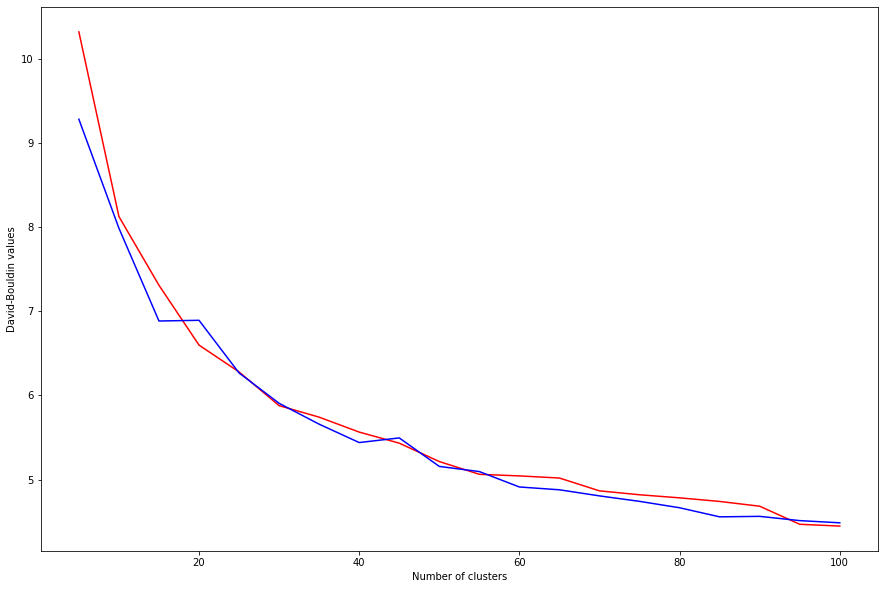

In [22]:
plt.figure(figsize=(15,10))
plt.plot(list(db_pca.keys()), list(db_pca.values()), color="red")
plt.plot(list(db_svd.keys()), list(db_svd.values()), color="blue")
plt.xlabel("Number of clusters")
plt.ylabel("David-Bouldin values")
plt.show()

#### Silhouette Score

A Silhouette Score ranges between -1 to 1. A high score means that comments are well matched to their own cluster and poorly matched to their neighborhood clusters. 

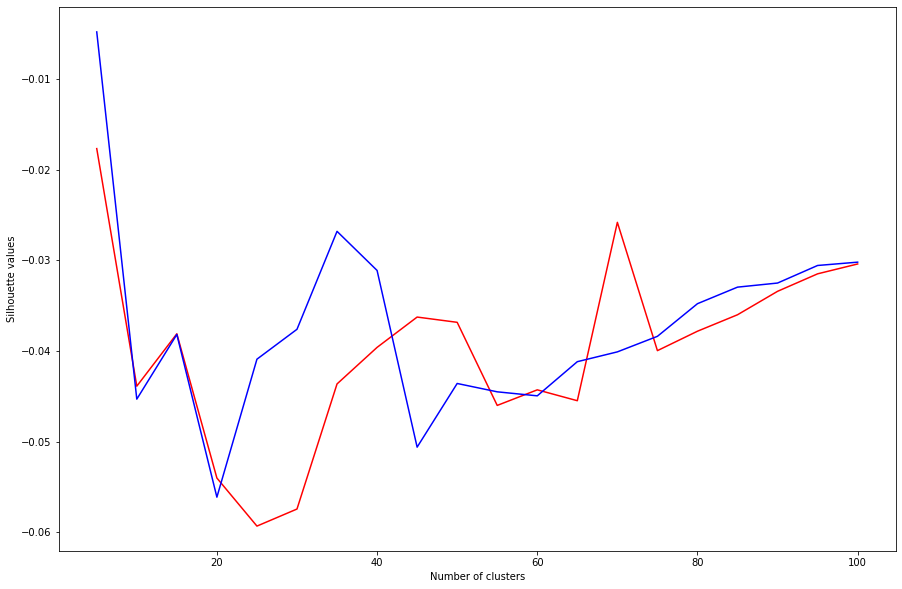

In [53]:
plt.figure(figsize=(15,10))
plt.plot(list(slc_pca.keys()), list(slc_pca.values()), color="red")
plt.plot(list(slc_svd.keys()), list(slc_svd.values()), color="blue")

plt.xlabel("Number of clusters")
plt.ylabel("Silhouette values")
plt.show()

## Clustering with DBSCAN

TODO: takes forevvvverrr

### Choosing eps parameter


In [7]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=100) # results remain roughly the same with n_neighbors<100
nbrs = neigh.fit(svd_embeddings)
distances, indices = nbrs.kneighbors(svd_embeddings)

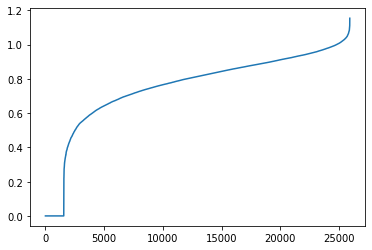

In [8]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

DBSCAN Parameter:
- eps: Max distance between two samples for them to be considered as in a neigborhood, default=0.5
- min_samples: Number of samples in a neighborhood for a point to be considered a core point, default = 5
- metric: Metric for calculating distance between instances in a feature array
- n_jobs: Used for parallelization, None means 1, -1 means using all processors

In [17]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.8, min_samples=100, metric="cosine").fit(svd_embeddings)

In [18]:
db

DBSCAN(eps=0.8, metric='cosine', min_samples=100)

In [19]:
components = db.components_
labels = db.labels_
core_sample_indices = db.core_sample_indices_

In [20]:
labels
(unique, counts) = np.unique(labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T

In [21]:
data["labels"] = labels

From docs: Cluster labels for each point in the dataset given to fit(). Noisy samples are given the label -1.

In [22]:
frequencies

array([[    0, 25914]])

In [23]:
import umap
reducer2 = umap.UMAP(n_components = 2,min_dist = .5)

embeddings_umap2 = reducer2.fit_transform(svd_embeddings)
embeddings_umap2.shape

(25914, 2)

Text(0.5, 0.98, 'Clustering with DBSCAN')

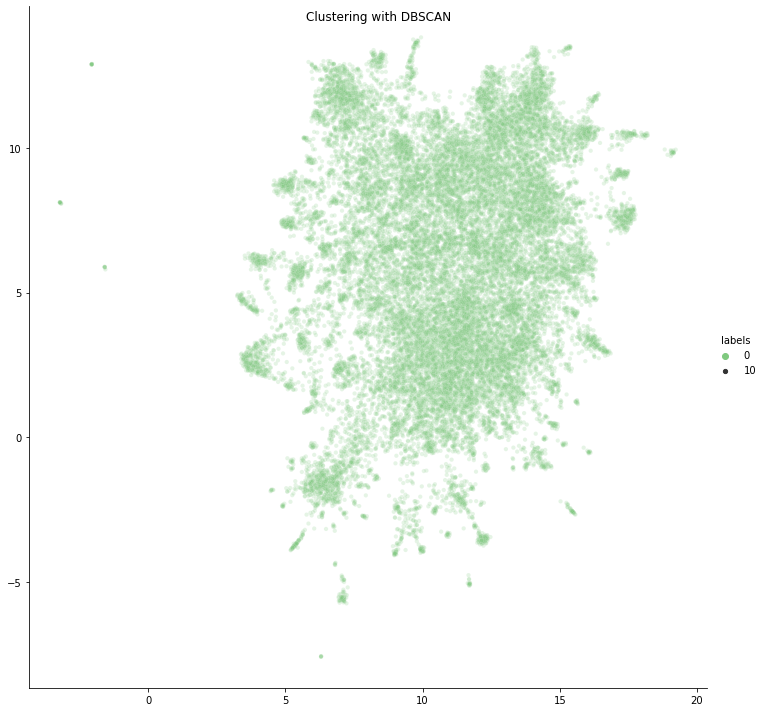

In [27]:
import seaborn as sns

palette_param = "Accent"
alpha_param = 0.2

plot = sns.relplot(x = embeddings_umap2[:, 0], y = embeddings_umap2[:, 1], size = 10, hue = data["labels"], palette = palette_param,alpha = alpha_param,height = 10)
plot.fig.suptitle('Clustering with DBSCAN')

## Clustering with Kmedoids